# Notebook Metadata

**Author**: Edgar Carrillo  
**Created**: 2024-02-29  
**Last Modified**: 2024-12-06  
**Affiliation**: Vanderbilt University  

This script identifies the column collapse condition for external water versus mass flux and column height. The core functionality is encapsulated in the `find_change_points` function, which determines the buoyancy threshold (or column collapse condition). 

To achieve this, the script calculates  $\frac{\Delta Z}{\Delta M_d} $, where $ Z $ represents the plume height and $ M_d $ represents the mass flux, for each run of external water $ w $. When a sudden change in plume height occurs at the buoyancy threshold, the standard deviation of $ \frac{\Delta Z}{\Delta M_d} $ effectively identifies this threshold. 

However, in cases with excessive external water, plume height changes less significantly near the buoyancy threshold, making the standard deviation more sensitive. To address this, the script dynamically adjusts the standard deviation threshold to accurately pinpoint the buoyancy threshold under these conditions.


In [3]:
import pandas as pd
import numpy as np

# Column definitions
COLUMNS = {
    "mass_flux_total": 'mass flux total (kg/s)',
    "external_water": 'mass fraction water added',
    "plume_height": 'calculated heigth (km)',
    "dry_plume_height": 'dry plume height (km)',
    "delta_z": 'delta z (km)',
    "mass_flux": 'mass flux (kg/s)',
    "vent_diameter": 'vent diameter (m)',
    "initial_velocity": 'initial velocity (m/s)',
    "mixture_density": 'mixture density (kg/m3)',
    "delta_sparks": 'delta z from sparks Z (km)',
    "temperature": 'T_mix'
}

# File paths
input_file_path = '../data/input/plumeria_data.csv'  
output_file_path = '../data/output/notebook_output_of_collapse_conditions.csv'

# Read the input CSV file into a DataFrame
df = pd.read_csv(input_file_path)

# Drop NaN values in the 'vent diameter' column and reset the index
df = df.dropna(subset=[COLUMNS["vent_diameter"]]).reset_index(drop=True)

# Define conditions for creating sub-DataFrames
conditions = [
    (df[COLUMNS["initial_velocity"]] == vel) & (df['magma temperature (c)'] == temp)
    for vel in [75, 100, 125] for temp in [700, 900, 1100]
]

# Generate a list of water fraction values
w_list = [w / 100 for w in range(61)]

# Function to identify Ri borders based on changes in plume height
def ri_borders(df_condition, water_fraction):
    df_w = df_condition.loc[df_condition[COLUMNS["external_water"]] == water_fraction]
    df_w = df_w.sort_values(by=[COLUMNS["mass_flux"]])
    df_w['diff'] = df_w[COLUMNS["plume_height"]].diff().abs()
    std_dev = np.std(df_w['diff'].dropna())

    temp = df_w['magma temperature (c)'].values[0]
    velocity = df_w[COLUMNS["initial_velocity"]].values[0]

    # Threshold adjustment based on conditions
    if water_fraction >= 0.3:
        threshold = 6 * std_dev
    elif water_fraction >= 0.3 and temp == 700 and velocity == 75:
        threshold = 10 * std_dev
    elif water_fraction < 0.3 and 1000 < temp < 1100 and velocity > 100:
        threshold = 1.5 * std_dev
    elif water_fraction < 0.3 and temp == 1000 and velocity == 125:
        threshold = 3 * std_dev
    else:
        threshold = 8 * std_dev

    return df_w[df_w['diff'] > threshold].index

# Collect rows where changes exceed thresholds
selected_rows = []

for condition in conditions:
    df_condition = df.loc[condition]
    for water_fraction in w_list:
        change_points = ri_borders(df_condition, water_fraction)
        if not change_points.empty:
            selected_rows.append(df.loc[change_points])

# Combine selected rows into a single DataFrame
result = pd.concat(selected_rows) if selected_rows else pd.DataFrame()

# Save results to a CSV file
result.to_csv(output_file_path, index=False)

print(f"Done! CSV file saved at {output_file_path}")

Done! CSV file saved at ../data/output/notebook_output_of_collapse_conditions.csv


DataFrame 0 shape: (31, 44)
DataFrame 1 shape: (46, 44)
DataFrame 2 shape: (52, 44)
DataFrame 3 shape: (30, 44)
DataFrame 4 shape: (46, 44)
DataFrame 5 shape: (53, 44)
DataFrame 6 shape: (29, 44)
DataFrame 7 shape: (46, 44)
DataFrame 8 shape: (58, 44)


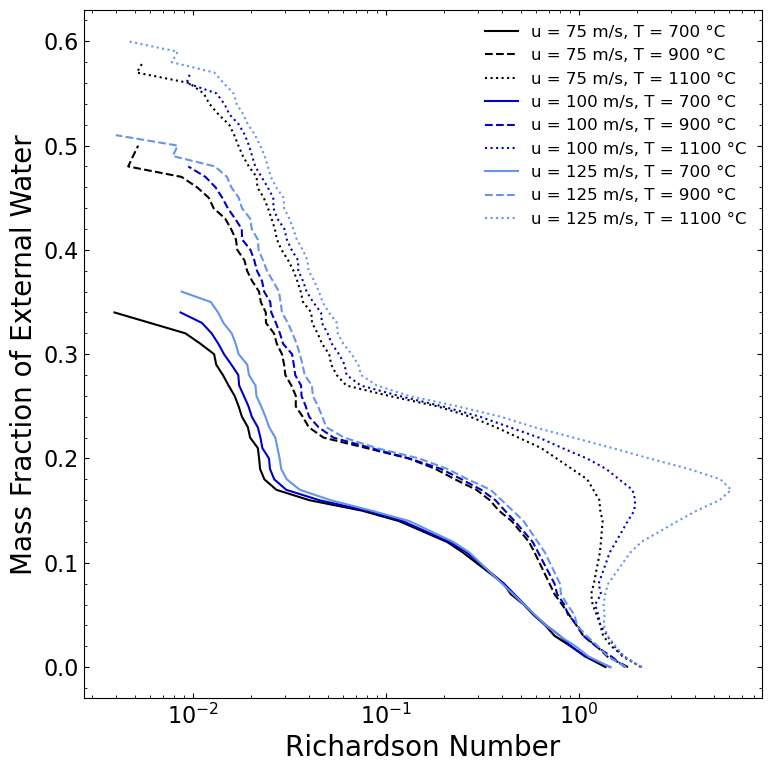

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define constants and column names
COLUMN_NAMES = {
    "mass_flux_total": 'mass flux total (kg/s)',  # M_T
    "external_water": 'mass fraction water added',  # w
    "plume_height": 'calculated height (km)',  # Z
    "dry_plume_height": 'dry plume height (km)',
    "delta_z": 'delta z (km)',
    "mass_flux": 'mass flux (kg/s)',  # M_d
    "vent_diameter": 'vent diameter (m)',
    "sparks_height": "sparks heigth (km)",
    "initial_velocity": 'initial velocity (m/s)',
    "mixture_density": 'mixture density (kg/m3)',
    "delta_sparks": 'delta z from sparks Z (km)',
    "temperature": 'T_mix',
    "humidity": 'Relative humidity, %',
    "ri": 'Ri',
    "thermal_ri": 'Ri_T',
}

PLOT_PARAMS = {
    'legend.title_fontsize': 'xx-small',
    'axes.labelsize': 20,
    'font.size': 16,
    'legend.fontsize': 12,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.top': True,
    'ytick.right': True,
    'figure.autolayout': True,
}

# Load data
csv_path = '../data/output/notebook_output_of_collapse_conditions.csv'  # Update as needed
df = pd.read_csv(csv_path)

# Filter out failed run data
df = df.loc[~df[COLUMN_NAMES["external_water"]].isin([0.10, 0.09, 0.13])]

# Define filtering conditions for sub-DataFrames
def filter_data(df, velocity, temperature, water_upper_limit=None, exclude_water=None):
    query = (
        (df[COLUMN_NAMES["initial_velocity"]] == velocity)
        & (df['magma temperature (c)'] == temperature)
    )
    if water_upper_limit:
        query &= df[COLUMN_NAMES["external_water"]] < water_upper_limit
    if exclude_water:
        query &= ~df[COLUMN_NAMES["external_water"]].isin(exclude_water)
    return df.loc[query]

# Create sub-DataFrames
data_frames = [
    filter_data(df, 75, 700, 0.35),
    filter_data(df, 75, 900, exclude_water=[0.08]),
    filter_data(df, 75, 1100, exclude_water=[0.17]),
    filter_data(df, 100, 700),
    filter_data(df, 100, 900),
    filter_data(df, 100, 1100),
    filter_data(df, 125, 700, 0.38, exclude_water=[0.06]),
    filter_data(df, 125, 900, exclude_water=[0.12]),
    filter_data(df, 125, 1100),
]

# Reduce data to unique rows for plotting
def df_reduced(df):
    high = df[df[COLUMN_NAMES["external_water"]] > 0.4]
    low = df[df[COLUMN_NAMES["external_water"]] <= 0.4].sort_values(by=[COLUMN_NAMES["mass_flux"]])
    combined = pd.concat([
        high.drop_duplicates(subset=COLUMN_NAMES["external_water"]),
        low.drop_duplicates(subset=COLUMN_NAMES["external_water"]),
    ])
    return combined.reset_index(drop=True)

dataframes_reduced = [df_reduced(df) for df in data_frames]

# Verify data before plotting
for idx, df in enumerate(dataframes_reduced):
    print(f"DataFrame {idx} shape: {df.shape}")

# Plot parameters
plt.rcParams.update(PLOT_PARAMS)
size = [8, 8]
ri_to_plot = COLUMN_NAMES["ri"]
save_plots = False

# Plotting
f, ax = plt.subplots(figsize=size)

colors = ['black', 'mediumblue', 'cornflowerblue']
linestyles = ['solid', 'dashed', 'dotted']
labels = [
    ('u = 75 m/s', [700, 900, 1100]),
    ('u = 100 m/s', [700, 900, 1100]),
    ('u = 125 m/s', [700, 900, 1100]),
]

for idx, (color, (velocity_label, temps)) in enumerate(zip(colors, labels)):
    for temp_idx, temp in enumerate(temps):
        linestyle = linestyles[temp_idx]
        label = f'{velocity_label}, T = {temp} °C'
        sns.lineplot(
            data=dataframes_reduced[idx * len(temps) + temp_idx],
            x=ri_to_plot,
            y=COLUMN_NAMES["external_water"],
            color=color,
            linestyle=linestyle,
            sort=True,
            orient = 'y',
            label=label,
        )


# Customize axes
xlabel = "Thermal Richardson Number" if ri_to_plot == COLUMN_NAMES["thermal_ri"] else "Richardson Number"
ax.set(xlabel=xlabel, ylabel='Mass Fraction of External Water', xscale='log')
ax.minorticks_on()
plt.legend(loc=0, frameon=False)

# Save or show the plot
if save_plots:
    plt.savefig('sample.png', bbox_inches="tight")
else:
    plt.show()